In [5]:
library(tidyverse)
library(modelr)

# Lecture 19: More modeling basics

The `sim2` dataset is another example data set containing continuous and categorical data:

In [7]:
sim2 %>% print

# A tibble: 40 x 2
       x          y
   <chr>      <dbl>
 1     a  1.9353632
 2     a  1.1764886
 3     a  1.2436855
 4     a  2.6235489
 5     a  1.1120381
 6     a  0.8660030
 7     a -0.9100875
 8     a  0.7207628
 9     a  0.6865540
10     a  2.0673079
# ... with 30 more rows


Now `x` is a categorical variable with four levels `a`-`d`:

In [13]:
factor(sim2$x)

 [1] a a a a a a a a a a b b b b b b b b b b c c c c c c c c c c d d d d d d d d
[39] d d
Levels: a b c d

We saw last lecture that the formula `y ~ x` when applied to `sim2` would produce the following model matrix:

In [18]:
m = sim2 %>% model_matrix(y ~ x) %>% print

# A tibble: 40 x 4
   `(Intercept)`    xb    xc    xd
           <dbl> <dbl> <dbl> <dbl>
 1             1     0     0     0
 2             1     0     0     0
 3             1     0     0     0
 4             1     0     0     0
 5             1     0     0     0
 6             1     0     0     0
 7             1     0     0     0
 8             1     0     0     0
 9             1     0     0     0
10             1     0     0     0
# ... with 30 more rows


Each of the levels of `x` except one (`x=a` in this case) becomes a column in the model matrix.

Based on this model matrix, running `lm(y ~ x, data = sim2)` estimates the model

In [21]:
lm(y ~ x, data = sim2)


Call:
lm(formula = y ~ x, data = sim2)

Coefficients:
(Intercept)           xb           xc           xd  
     1.1522       6.9639       4.9750       0.7588  


Let's think about what these estimates mean. In math this model is:

$$y = a_0 + a_1\texttt{xb} + a_2 \texttt{xc} + a_3 \texttt{xd}$$

The first observation in `sim2` is:

In [22]:
sim2 %>% slice(1)

  x y       
1 a 1.935363

and the first row of the model matrix is

In [19]:
m[1,]

  (Intercept) xb xc xd
1 1           0  0  0 

Since `xb == xc == xd == 0`, the regression equation for the first observation becomes 

$$y = a_0 + a_1\times 0 + a_2\times 0 + a_3 \times 0 = a_0.$$

So $a_0$ is the intercept term for the `x=='a'` group.

In [ ]:
Similarly,

In [25]:
sim2 %>% slice(20)
m[20,]

  x y      
1 b 6.08828

  (Intercept) xb xc xd
1 1           1  0  0 

so the regression equation for the 20th observation is 

$$y = a_0 + a_1\times 1 + a_2\times 0 + a_3 \times 0 = a_0 + a_1.$$


In effect, `lm(y ~ x, data = sim2)` estimates four intercept-only models. For the `x=='a'` group the intercept is $a_0$; for `x=='d'` it's $a_0 + a_3$; and so forth.

We can verify this by using the same techniques that we used to visualize continuous model fits in last lecture:

In [29]:
model = lm(y ~ x, sim2)
(df = sim2 %>% data_grid(x) %>% add_predictions(model))

  x pred    
1 a 1.152166
2 b 8.116039
3 c 6.127191
4 d 1.910981

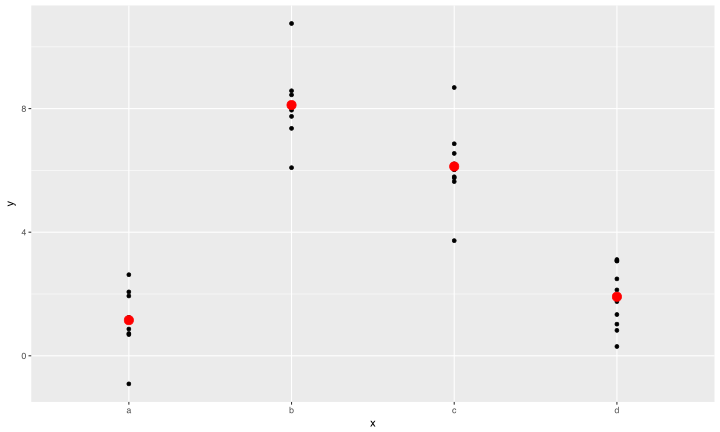

In [30]:
ggplot(sim2) + geom_point(aes(x = x, y = y)) + 
    geom_point(data = df, aes(x = x, y = pred), color="red", size=4)

### Categorical and continuous data
`modelr::sim3` has both continuous and categorical data:

In [31]:
sim3 %>% print

# A tibble: 120 x 5
      x1     x2   rep          y    sd
   <int> <fctr> <int>      <dbl> <dbl>
 1     1      a     1 -0.5707363     2
 2     1      a     2  1.1841503     2
 3     1      a     3  2.2373204     2
 4     1      b     1  7.4366963     2
 5     1      b     2  8.5182934     2
 6     1      b     3  7.7239098     2
 7     1      c     1  6.5067480     2
 8     1      c     2  5.7900643     2
 9     1      c     3  6.0721817     2
10     1      d     1  2.1096727     2
# ... with 110 more rows


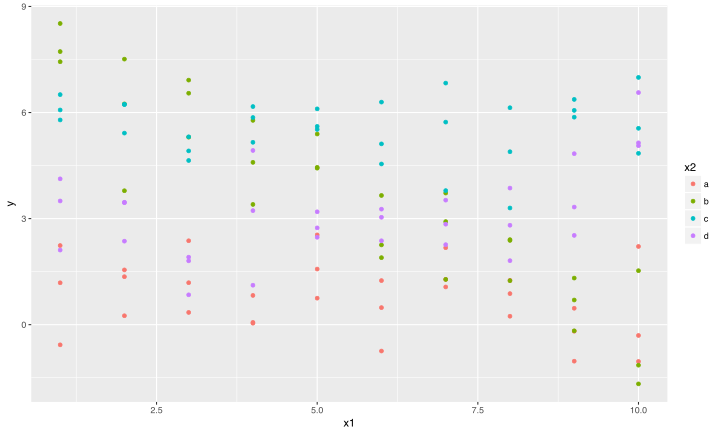

In [32]:
ggplot(sim3, aes(x1, y)) + 
  geom_point(aes(colour = x2))

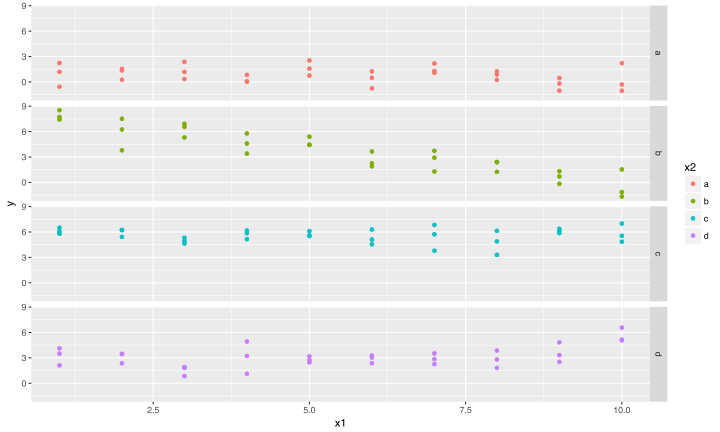

In [34]:
ggplot(sim3, aes(x1, y)) + geom_point(aes(colour = x2)) + facet_grid(x2 ~ .)

One way to model this data would be by adding both `x1` and `x2` to the model:

In [43]:
mod1 = lm(y ~ x1 + x2, data = sim3)
summary(mod1)


Call:
lm(formula = y ~ x1 + x2, data = sim3)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.4674 -0.8524 -0.0729  0.7886  4.3005 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.87167    0.38738   4.832 4.22e-06 ***
x1          -0.19674    0.04871  -4.039 9.72e-05 ***
x2b          2.88781    0.39571   7.298 4.07e-11 ***
x2c          4.80574    0.39571  12.145  < 2e-16 ***
x2d          2.35959    0.39571   5.963 2.79e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.533 on 115 degrees of freedom
Multiple R-squared:  0.5911,	Adjusted R-squared:  0.5768 
F-statistic: 41.55 on 4 and 115 DF,  p-value: < 2.2e-16


As before, this estimates a different intercept for each level of `x2`, but a common slope term.

Another option is to add an *interaction* between `x1` and `x2`:

In [42]:
mod2 = lm(y ~ x1 * x2, data = sim3)
summary(mod2)$coefficients

            Estimate    Std. Error t value    Pr(>|t|)    
(Intercept)  1.30124266 0.40399810  3.2209128 1.672947e-03
x1          -0.09302444 0.06511019 -1.4287233 1.558668e-01
x2b          7.06937991 0.57133959 12.3733416 1.091786e-22
x2c          4.43089525 0.57133959  7.7552743 4.406608e-12
x2d          0.83455115 0.57133959  1.4606920 1.468997e-01
x1:x2b      -0.76028528 0.09207971 -8.2568164 3.301095e-13
x1:x2c       0.06815284 0.09207971  0.7401505 4.607574e-01
x1:x2d       0.27727920 0.09207971  3.0112952 3.215600e-03

Now we get a number of new terms of the form `x1:x2<lvl>`. What do these represent? Let's again look at the model matrix:

In [48]:
m = sim3 %>% model_matrix(y ~ x1 * x2) %>% print

# A tibble: 120 x 8
   `(Intercept)`    x1   x2b   x2c   x2d `x1:x2b` `x1:x2c` `x1:x2d`
           <dbl> <dbl> <dbl> <dbl> <dbl>    <dbl>    <dbl>    <dbl>
 1             1     1     0     0     0        0        0        0
 2             1     1     0     0     0        0        0        0
 3             1     1     0     0     0        0        0        0
 4             1     1     1     0     0        1        0        0
 5             1     1     1     0     0        1        0        0
 6             1     1     1     0     0        1        0        0
 7             1     1     0     1     0        0        1        0
 8             1     1     0     1     0        0        1        0
 9             1     1     0     1     0        0        1        0
10             1     1     0     0     1        0        0        1
# ... with 110 more rows


The `x1:x2<lvl>` terms are again equal to 1 only if the corresponding observation had `x2==<lvl>`. For example, the first observation had `x2=='a'`, so the regression equation in this case is 

$$
\begin{align}
y &= a_0 + a_1 \texttt{x1} + a_2\texttt{x2b} + \cdots + a_5 \times \texttt{x1} \times \texttt{x1:x2b} + \cdots + a_7 \times \texttt{x1} \times \texttt{x1:x2d} \\
  &= a_0 + a_1 \texttt{x1} + a_2\times 0 + \cdots + a_5 \times 0 + \cdots + a_7 \times 0 \\
  &= a_0 + a_1 \texttt{x1}
\end{align}
$$

On the other hand, the 20th observation had

In [50]:
m[20,]

  (Intercept) x1 x2b x2c x2d x1:x2b x1:x2c x1:x2d
1 1           2  0   1   0   0      2      0     

Repeating the same calculation as above, we get that the regression equation for observations with `x2=='c'` is equal to 

$$
y = (a_0 + a_3) + (a_1 + a_6)\times \texttt{x1}.
$$

We see that in this model, each different group of `x2` is allowed to have a different slope as well as intercept.

Let's compare `mod1` and `mod2`. To do this we will use the `gather_predictions` function, which takes a data grid and one or more models and adds a new row for each prediction for each model:

In [52]:
grid = sim3 %>% data_grid(x1, x2) %>% gather_predictions(mod1, mod2) %>% print

# A tibble: 80 x 4
   model    x1     x2     pred
   <chr> <int> <fctr>    <dbl>
 1  mod1     1      a 1.674928
 2  mod1     1      b 4.562739
 3  mod1     1      c 6.480664
 4  mod1     1      d 4.034515
 5  mod1     2      a 1.478190
 6  mod1     2      b 4.366001
 7  mod1     2      c 6.283926
 8  mod1     2      d 3.837777
 9  mod1     3      a 1.281453
10  mod1     3      b 4.169263
# ... with 70 more rows


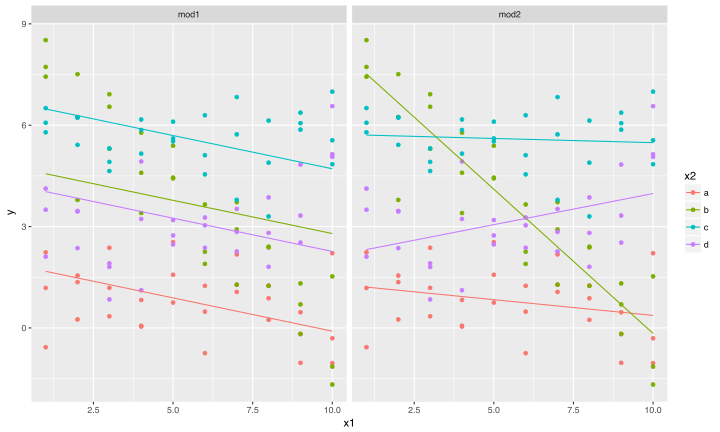

In [56]:
ggplot(sim3, aes(x1, y, color = x2)) + geom_point() + 
  geom_line(data = grid, aes(y = pred)) + 
  facet_grid( ~ model)

### Selecting between the models
How should we decide which model to use? We can make the same plots using `gather_residuals` instead of `gather_predicitons`:

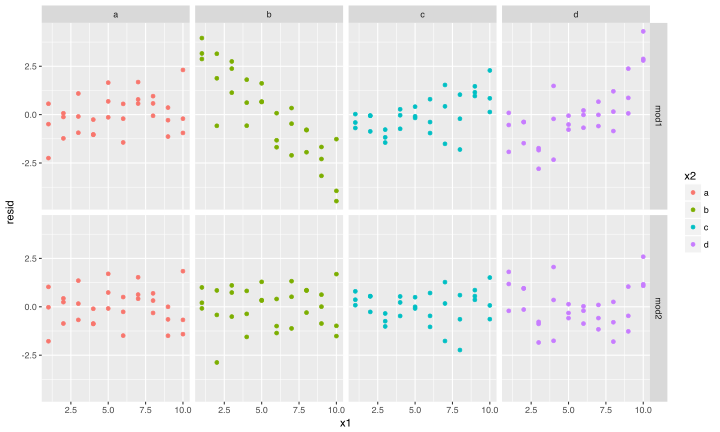

In [57]:
sim3 = sim3 %>% gather_residuals(mod1, mod2)

ggplot(sim3, aes(x1, resid, colour = x2)) + 
  geom_point() + 
  facet_grid(model ~ x2)

Which model's residuals look more random to you?

### Two continuous variables
The `sim4` data set contains two continuous variables:

In [58]:
print(sim4)

# A tibble: 300 x 4
      x1         x2   rep           y
   <dbl>      <dbl> <int>       <dbl>
 1    -1 -1.0000000     1  4.24767769
 2    -1 -1.0000000     2  1.20599701
 3    -1 -1.0000000     3  0.35347770
 4    -1 -0.7777778     1 -0.04665814
 5    -1 -0.7777778     2  4.63868987
 6    -1 -0.7777778     3  1.37709540
 7    -1 -0.5555556     1  0.97522088
 8    -1 -0.5555556     2  2.49963753
 9    -1 -0.5555556     3  2.70474837
10    -1 -0.3333333     1  0.55751522
# ... with 290 more rows


We will again compare two models, one with two effects for `x1` and `x2`, and the second with an interaction term:

In [59]:
mod1 = lm(y ~ x1 + x2, data = sim4)
mod2 = lm(y ~ x1 * x2, data = sim4)

With continuous data the behaviour of `x1 * x2` is a bit different -- it will be the actual arithemetic product of the two variables:

In [62]:
model_matrix(sim4, y ~ x1 * x2) %>% print

# A tibble: 300 x 4
   `(Intercept)`    x1         x2   `x1:x2`
           <dbl> <dbl>      <dbl>     <dbl>
 1             1    -1 -1.0000000 1.0000000
 2             1    -1 -1.0000000 1.0000000
 3             1    -1 -1.0000000 1.0000000
 4             1    -1 -0.7777778 0.7777778
 5             1    -1 -0.7777778 0.7777778
 6             1    -1 -0.7777778 0.7777778
 7             1    -1 -0.5555556 0.5555556
 8             1    -1 -0.5555556 0.5555556
 9             1    -1 -0.5555556 0.5555556
10             1    -1 -0.3333333 0.3333333
# ... with 290 more rows


Note that R has automatically added in the individual effects for `x1` and `x2`. Very rarely do you want to have an interaction effect without the individual effects as well. Should you want to do so, the `:` can be used in place of `*`:

In [63]:
model_matrix(sim4, y ~ x1 : x2) %>% print

# A tibble: 300 x 2
   `(Intercept)`   `x1:x2`
           <dbl>     <dbl>
 1             1 1.0000000
 2             1 1.0000000
 3             1 1.0000000
 4             1 0.7777778
 5             1 0.7777778
 6             1 0.7777778
 7             1 0.5555556
 8             1 0.5555556
 9             1 0.5555556
10             1 0.3333333
# ... with 290 more rows


Do look at our the two models' predictions we will use a similar pattern as before. However, instead of using the `data_grid` function directly, which would generate a row for every unique observation of `x1` and `x2`, we will take a range over the values that we observed using the `seq_range` function.

In [65]:
grid = sim4 %>% 
  data_grid(
    x1 = seq_range(x1, 5), 
    x2 = seq_range(x2, 5) 
  ) %>% 
  gather_predictions(mod1, mod2) %>% print

# A tibble: 50 x 4
   model    x1    x2       pred
   <chr> <dbl> <dbl>      <dbl>
 1  mod1  -1.0  -1.0  0.9963094
 2  mod1  -1.0  -0.5 -0.3949484
 3  mod1  -1.0   0.0 -1.7862061
 4  mod1  -1.0   0.5 -3.1774639
 5  mod1  -1.0   1.0 -4.5687216
 6  mod1  -0.5  -1.0  1.9071424
 7  mod1  -0.5  -0.5  0.5158847
 8  mod1  -0.5   0.0 -0.8753731
 9  mod1  -0.5   0.5 -2.2666308
10  mod1  -0.5   1.0 -3.6578886
# ... with 40 more rows


To visualize the two models we need to plot in two dimensions. For this we will use the `geom_tile` geometry, with lighter colors correpsonding to higher predicted values of `y`:

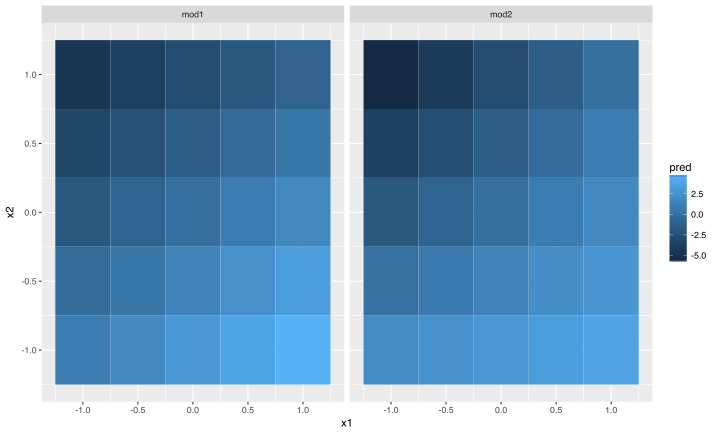

In [67]:
ggplot(grid, aes(x1, x2)) + geom_tile(aes(fill = pred)) + facet_wrap(~ model)

These plots look almost identical to me. Let's try visualizing in a different way. The following plots show the predicted value plotted against one of the continuous variables, grouped by levels of the other predictor:

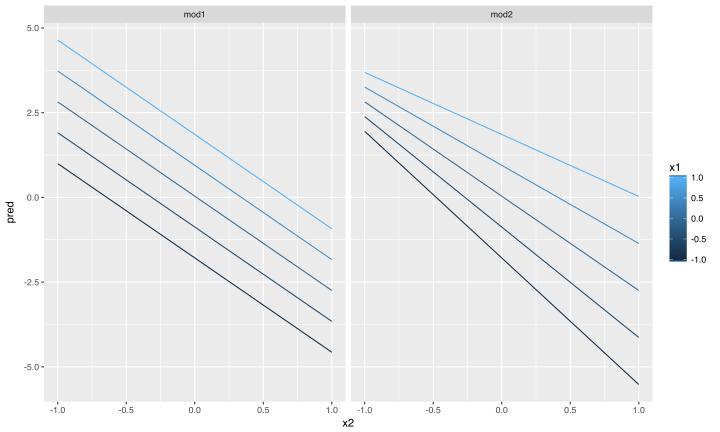

In [73]:
ggplot(grid, aes(x2, pred, colour = x1, group = x1)) + geom_line() + facet_wrap(~ model)

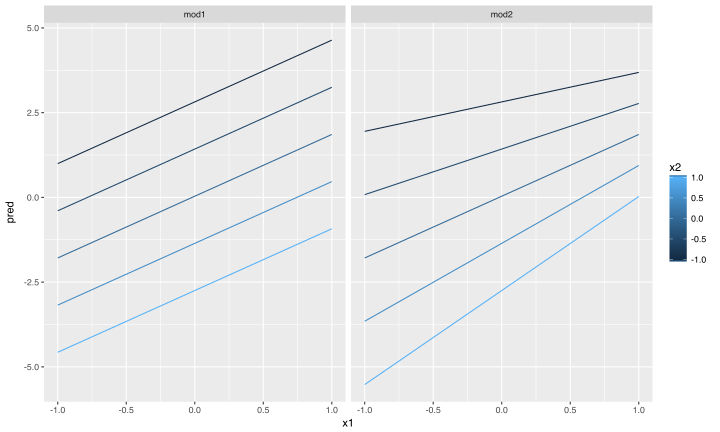

In [74]:
ggplot(grid, aes(x1, pred, colour = x2, group = x2)) + geom_line() + facet_wrap(~ model)

### Transformations
Some times we wish to transform the data before fitting a linear model. We saw an example of this already with the diamonds data:

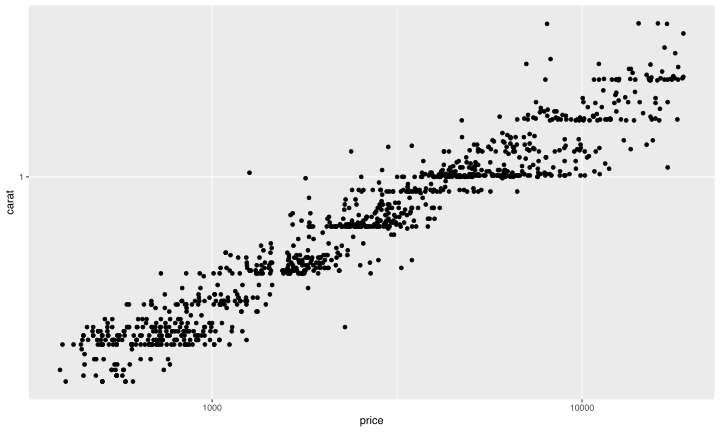

In [80]:
diamonds %>% sample_n(1000) %>% ggplot + geom_point(aes(x = price, y = carat)) + 
    scale_x_log10() + scale_y_log10()

It is possible to use transformations directly in model formulas:

In [81]:
diamonds %>% model_matrix(log(price) ~ log(carat)) %>% print

# A tibble: 53,940 x 2
   `(Intercept)` `log(carat)`
           <dbl>        <dbl>
 1             1    -1.469676
 2             1    -1.560648
 3             1    -1.469676
 4             1    -1.237874
 5             1    -1.171183
 6             1    -1.427116
 7             1    -1.427116
 8             1    -1.347074
 9             1    -1.514128
10             1    -1.469676
# ... with 53,930 more rows


Most mathematical functions, including `log`, `exp`, `sin`, `cos`, and `sqrt`, work exactly as expected. If your transformation involves `+`, `*` or `^` then you have to wrap the transformation using a special `I` function:

In [85]:
sim4 %>% model_matrix(y ~ x1 + x2 + x2^2) %>% print ## wrong

# A tibble: 300 x 3
   `(Intercept)`    x1         x2
           <dbl> <dbl>      <dbl>
 1             1    -1 -1.0000000
 2             1    -1 -1.0000000
 3             1    -1 -1.0000000
 4             1    -1 -0.7777778
 5             1    -1 -0.7777778
 6             1    -1 -0.7777778
 7             1    -1 -0.5555556
 8             1    -1 -0.5555556
 9             1    -1 -0.5555556
10             1    -1 -0.3333333
# ... with 290 more rows


Transformations are useful because they let us use the linear model to study non-linear functions. For example, in calculus II you learned that any smooth function can be (locally) approximated by polynomials:

$$f(x) \approx f(0) + f'(0)x + f''(0)x^2,$$

for $x$ near zero. This is just a linear model 

$$y = a_0 + a_1 x_1 + a_2 x_2$$ 

for $a_i = f^{(i)}(0)$ and $x_i = x^i$. 

R provides a special command `poly(x, k)` which adds all monomials up to order $k$ in `x`:

In [87]:
sim4 %>% model_matrix(y ~ poly(x1, 4)) %>% print

# A tibble: 300 x 5
   `(Intercept)` `poly(x1, 4)1` `poly(x1, 4)2` `poly(x1, 4)3` `poly(x1, 4)4`
           <dbl>          <dbl>          <dbl>          <dbl>          <dbl>
 1             1     -0.0904534     0.09534626    -0.08278374     0.06145099
 2             1     -0.0904534     0.09534626    -0.08278374     0.06145099
 3             1     -0.0904534     0.09534626    -0.08278374     0.06145099
 4             1     -0.0904534     0.09534626    -0.08278374     0.06145099
 5             1     -0.0904534     0.09534626    -0.08278374     0.06145099
 6             1     -0.0904534     0.09534626    -0.08278374     0.06145099
 7             1     -0.0904534     0.09534626    -0.08278374     0.06145099
 8             1     -0.0904534     0.09534626    -0.08278374     0.06145099
 9             1     -0.0904534     0.09534626    -0.08278374     0.06145099
10             1     -0.0904534     0.09534626    -0.08278374     0.06145099
# ... with 290 more rows


Let's see an example of how transformations can be used to fit non-linear functions using the linear model. We will make a new dat aset `sim5` with `y` and `x` that are non-linearly related:

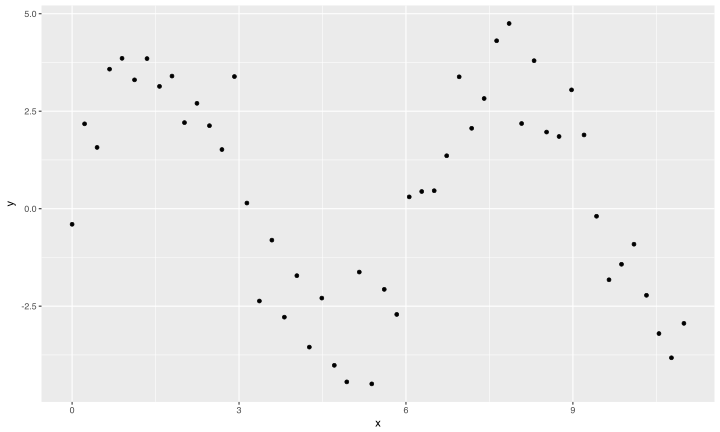

In [92]:
sim5 <- tibble(
  x = seq(0, 3.5 * pi, length = 50),
  y = 4 * sin(x) + rnorm(length(x))
)
sim5 %>% ggplot + geom_point(aes(x, y))

If we fit a regression line, the fit is of course not good:

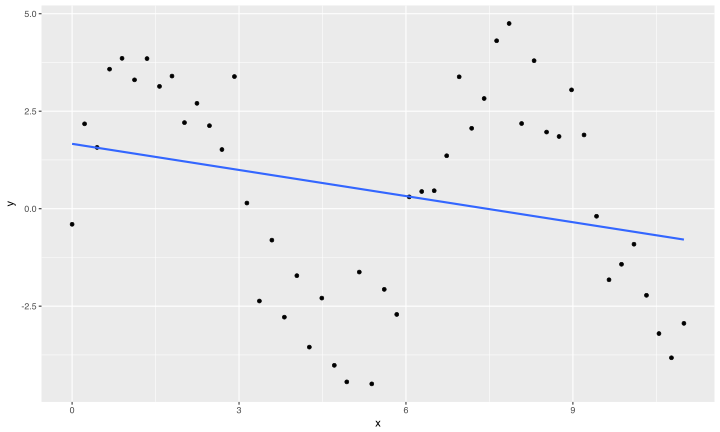

In [95]:
sim5 %>% ggplot(aes(x, y)) + geom_point() + geom_smooth(method = 'lm', formula = y ~ x, se = F)

Now we will create five linear models that include increasingly higher powers of $x$:

In [160]:
models = 1:6 %>% map(~ lm(y ~ poly(x, .), data = sim5))

[1] 1 2 3 4 5 6

In [183]:
pred = map(models, add_predictions, data = sim5) %>% 
       setNames(str_c("model", seq_along(models))) %>%
       bind_rows(.id = "model")

# A tibble: 300 x 4
    model         x          y     pred
    <chr>     <dbl>      <dbl>    <dbl>
 1 model1 0.0000000 -0.3996315 1.663602
 2 model1 0.2243995  2.1767851 1.613483
 3 model1 0.4487990  1.5718859 1.563364
 4 model1 0.6731984  3.5791890 1.513245
 5 model1 0.8975979  3.8571579 1.463126
 6 model1 1.1219974  3.3046999 1.413006
 7 model1 1.3463969  3.8497930 1.362887
 8 model1 1.5707963  3.1375897 1.312768
 9 model1 1.7951958  3.4017135 1.262649
10 model1 2.0195953  2.2079573 1.212530
# ... with 290 more rows


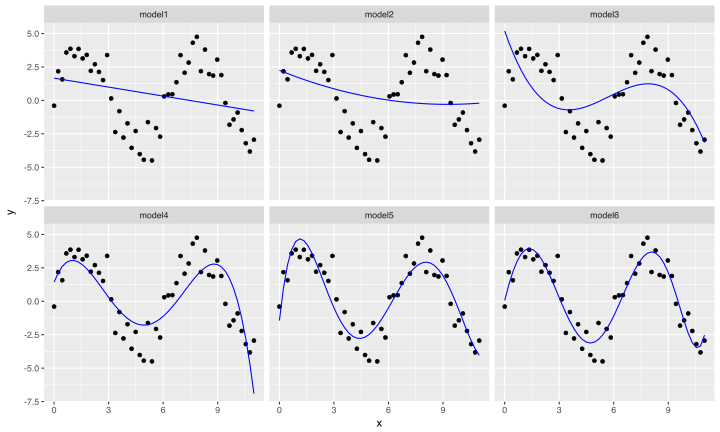

In [185]:
ggplot(pred, aes(group=model)) + geom_point(aes(x, y)) + 
    geom_line(aes(x, pred), colour="blue") +
    facet_wrap(~ model)

These plots show that higher order polynomials can fit these data pretty well, at least over the range of data that was actually observed. But what if we want to predict outside of the observed range? I will repeat the above commands, but this time using `expand=` option of `seq_range` to generate data outside of the range in `sim5`:

In [197]:
sim5_exp = sim5 %>% data_grid(x = seq_range(x, 20, expand = .1))
pred_exp = map(models, add_predictions, data = sim5_exp) %>% 
           setNames(str_c("model", seq_along(models))) %>%
           bind_rows(.id = "model")

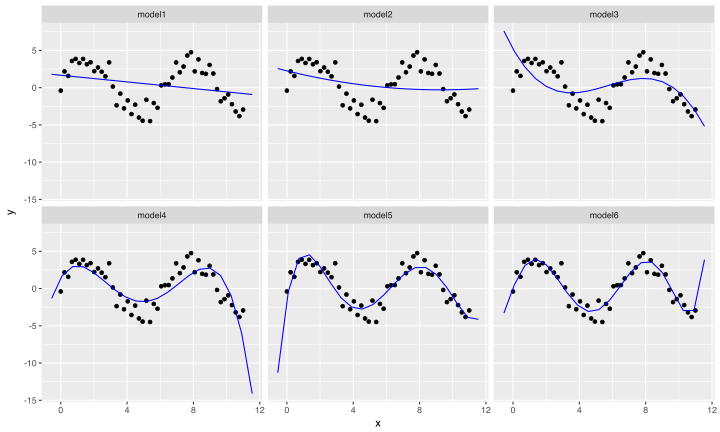

In [202]:
ggplot(pred_exp) +
    geom_point(data = sim5, aes(x = x, y = y)) +
    geom_line(aes(x, pred, group = model), colour="blue") +
    facet_wrap(~ model) 

We get bad predictions outside of the range of the observed data using polynomials. To fix this we can use *splines*, which are piecewise polynomials that do not blow up around the endpoints:

In [205]:
library(splines)
models = 1:6 %>% map(~ lm(y ~ ns(x, .), data = sim5))
sim5_exp = sim5 %>% data_grid(x = seq_range(x, 20, expand = .1))
pred_exp = map(models, add_predictions, data = sim5_exp) %>% 
           setNames(str_c("model", seq_along(models))) %>%
           bind_rows(.id = "model")

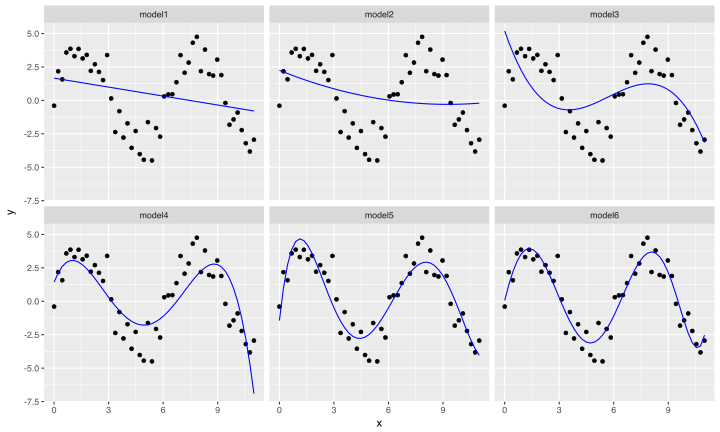

In [206]:
ggplot(pred, aes(group=model)) + geom_point(aes(x, y)) + 
    geom_line(aes(x, pred), colour="blue") +
    facet_wrap(~ model)

### Other types of models
The linear model is the simplest and most common model you will encounter in R. However, there are many other types of models that you can use. We will not discuss them in this class, but as you go further in statistics and data science you may find yourself need to use more powerful types of models.

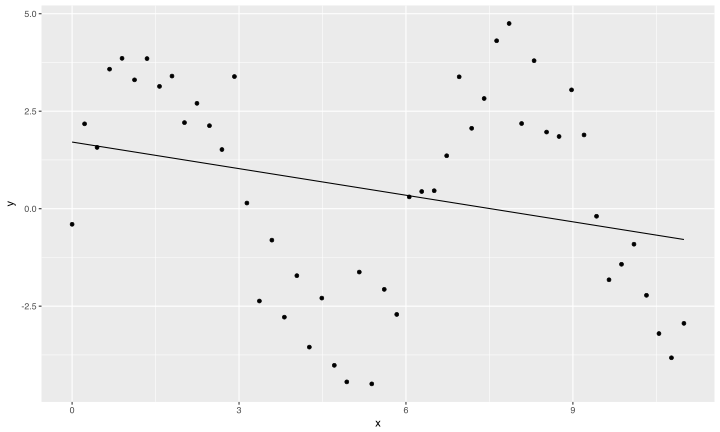

In [226]:
# model_cls = mgcv::gam
# model_cls = MASS::rlm
# model_cls = rpart::rpart
model_cls = MASS::rlm
model = model_cls(y ~ x, data = sim5)
sim5 %>% add_predictions(model) %>% ggplot +
    geom_point(aes(x, y)) + geom_line(aes(x, pred))